# Домашнее задание

* Получить точность 97.5% на валидации MNIST.
* Реализовать морфинг автоэнкодером (без формальных критериев — просто получите красивую гифку).
* Визуализировать MNIST автоэнкодером (обучить автоэнкодер с латентным пространством размерности 2 и вывести через scatter точки разного цвета).

### MNIST

In [93]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

torch.manual_seed(42)

In [31]:
def get_loader(train, batch_size):
    '''Cкачает мнист и сохранит где-то рядом.'''
    
    # Dataset в PyTorch -- это какой-то объект, который оборачивает сырые данные и делает с ними какой-нибудь препроцессинг
    dataset = datasets.MNIST('mnist', train=train, download=True,
        transform=transforms.ToTensor())
    
    # DataLoader делает из датасета генератор, который возвращает данные, сгруппированные по батчам
    loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)
    
    return loader
    
train = get_loader(True, 64)
val = get_loader(False, 64)

In [32]:
def accuracy(model, val):
    total = 0
    correct = 0
    for X, y in val:
        res = model(X)
        res = res.argmax(dim=1)
        total += res.shape[0]
        correct += (res == y).sum().item()
    return correct / total

In [141]:
model = nn.Sequential(
    nn.Conv2d(in_channels=1, out_channels=32, kernel_size=(3, 3)),
    nn.MaxPool2d(kernel_size=2, stride=2),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Flatten(),
    nn.Linear(32*13*13, 10),
    nn.LogSoftmax(dim=1)
)

In [142]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)
criterion = nn.NLLLoss()

In [143]:
train_losses = []
epoch_accuracy = []
for epoch in range(10):
    for X, y in train:
        optimizer.zero_grad()
        
        output = model(X)
        loss = criterion(output, y)
        loss.backward()
        
        train_losses.append(loss.item())
        
        optimizer.step()
    acc_test = accuracy(model, val)
    epoch_accuracy.append(acc_test)
    print(f"train: {accuracy(model, train)} test: {acc_test}")

train: 0.9762 test: 0.9728
train: 0.98005 test: 0.9739
train: 0.9830166666666666 test: 0.978
train: 0.9827 test: 0.9763
train: 0.9834 test: 0.9747
train: 0.9866666666666667 test: 0.9777
train: 0.98845 test: 0.9773
train: 0.98265 test: 0.9724
train: 0.9844166666666667 test: 0.9749
train: 0.98695 test: 0.9748


In [144]:
print(f"max accuracy: {np.max(epoch_accuracy)}  mean accuracy: {np.mean(epoch_accuracy)}")

max accuracy: 0.978  mean accuracy: 0.97528


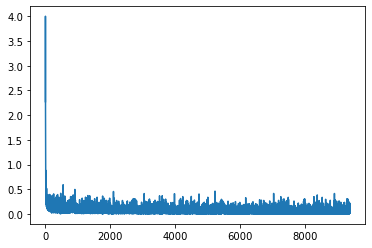

In [145]:
plt.plot(train_losses)
plt.show()

## Реализовать морфинг автоэнкодером 
без формальных критериев — просто получите красивую гифку.

In [108]:
from matplotlib import animation
from matplotlib.animation import FuncAnimation
from IPython.display import Video, display
import ffmpy

In [109]:
class Autoencoder(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.encode = nn.Sequential(
            nn.Linear(28 * 28, 100),
            nn.ReLU(),
            nn.Linear(100, 10),
        )
        
        self.decode = nn.Sequential(
            nn.Linear(10, 100),
            nn.ReLU(),
            nn.Linear(100, 28 * 28),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        return self.decode(self.encode(x))

model = Autoencoder()
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters())

In [112]:
for epoch in range(10):
    train_loss = 0
    for data, _ in train:
        data = data.view(-1, 784)
        
        optimizer.zero_grad()
        
        reconstructed = model(data)
        loss = criterion(data, reconstructed)
        
        loss.backward()

        train_loss += loss.item()
        optimizer.step()

    print('epoch %d: loss %.4f' % (epoch, train_loss / len(train)))

epoch 0: loss 0.0415
epoch 1: loss 0.0254
epoch 2: loss 0.0231
epoch 3: loss 0.0218
epoch 4: loss 0.0210
epoch 5: loss 0.0203
epoch 6: loss 0.0198
epoch 7: loss 0.0194
epoch 8: loss 0.0191
epoch 9: loss 0.0188


In [127]:
def get(x):
    return train.dataset[x][0].view(1, 784)

def imshow(img):
    pic = img.numpy().astype('float')
    plt.axis('off')
    return plt.imshow(pic, cmap='Greys', animated=True)

def morph(inputs, steps, delay, file_name='plot_morph.mp4'):
    latent = [model.encode(get(k)).data for k in inputs]
    fig = plt.figure()
    images = []
    
    for a, b in zip(latent, latent[1:] + [latent[0]]):
        for t in numpy.linspace(0, 1, steps):
            c = a * (1 - t) + b * t
            morphed = model.decode(c).data
            morphed = morphed.view(28, 28)
            images.append([imshow(morphed)])

    ani = animation.ArtistAnimation(fig, images, interval=delay)
    FFwriter = animation.FFMpegWriter(fps=30)
    ani.save(file_name, writer=FFwriter)
    display(Video(file_name))

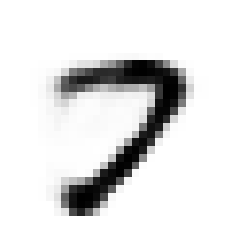

In [131]:
morph(np.random.randint(0, len(train.dataset), 30), 20, 30)

## Визуализировать MNIST автоэнкодером 
(обучить автоэнкодер с латентным пространством размерности 2 и вывести через scatter точки разного цвета).